# AlexNet challenge

Elaboración del alexnet challenge que consiste en:

    Recrear el modelo AlexNet desde cero en tensorflow/keras y en pyTorch
    Usar el dataset CIFAR10 para entrenar el modelo y comparar los resultados con los modelos preentrenados de pyTorch/TF

#### Imports necesarios:

In [37]:
# Get general purpose APIs first
import numpy as np
import matplotlib.pyplot as plt

# load tf/keras imports
import keras
import tensorflow as tf

# load the Pytorch APIs
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### PyTorch: Modelo pre-entrenado

Primeramente importamos el dataset `CIFAR10` de torch para generar los conjuntos de entrenamiento y prueba, usamos un batch de 64 para obtener una generalización mejor y un entrenamiento más rápido.

In [38]:
# 1. Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Cargamos el modelo pre-entrenado y definimos su salida para que coincida con el número de categorías de CIFAR10 (10).

In [39]:
# 2. Load Pretrained AlexNet
model = torchvision.models.alexnet(pretrained=True)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)  # 10 output classes


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"El total de parametros del modelo es: {count_params(model)}")

/home/omarjh/.cache/pypoetry/virtualenvs/diplomado-ia-Zsy5ah72-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omarjh/.cache/pypoetry/virtualenvs/diplomado-ia-Zsy5ah72-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


El total de parametros del modelo es: 57044810


Se define la función de perdida y el optimizador que se utilizará.

In [40]:
# 4. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. Move model to GPU if available
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se realiza el entrenamiento del modelo.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # Ensure labels are long type
        labels = labels.long()
        loss = criterion(outputs, labels)  # Corrected order: outputs, labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


Ahora se muestra la exactitud general obtenida por el modelo, medida en el conjunto de prueba y también las exactitudes para cada categoría de objeto.

In [42]:
# 7. Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 82.18 %


In [43]:

# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(
        f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 82.14 %
Accuracy of car   : 100.00 %
Accuracy of bird  : 83.54 %
Accuracy of cat   : 58.90 %
Accuracy of deer  : 70.91 %
Accuracy of dog   : 71.19 %
Accuracy of frog  : 85.71 %
Accuracy of horse : 87.50 %
Accuracy of ship  : 98.28 %
Accuracy of truck : 76.92 %


Finalmente, estas son un ejemplo de las imágenes utilizadas para entrenar el modelo.

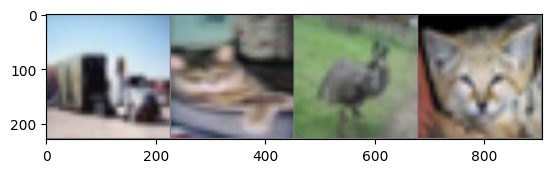

 truck || cat || bird || cat


In [44]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
                        for j in range(num_images)))

#### PyTorch: Modelo desde cero

In [45]:
class TorchAlexnet(nn.Module):

    def __init__(self, num_classes=10):
        super(TorchAlexnet, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.last = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.first(x)
        out = out.reshape(out.size(0), -1)
        out = self.last(out)
        return out

In [46]:
# 2. Load scratch AlexNet
model = TorchAlexnet()


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"El total de parametros del modelo es: {count_params(model)}")

El total de parametros del modelo es: 46790730


In [47]:
# 4. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. Move model to GPU if available
model.to(device)

TorchAlexnet(
  (first): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # Ensure labels are long type
        labels = labels.long()
        loss = criterion(outputs, labels)  # Corrected order: outputs, labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.044
[1,   200] loss: 1.683
[1,   300] loss: 1.536
[1,   400] loss: 1.424
[1,   500] loss: 1.362
[1,   600] loss: 1.298
[1,   700] loss: 1.219


In [ ]:
# 7. Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 58.93 %


In [ ]:
# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(
        f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 66.07 %
Accuracy of car   : 62.00 %
Accuracy of bird  : 45.57 %
Accuracy of cat   : 38.36 %
Accuracy of deer  : 30.91 %
Accuracy of dog   : 54.24 %
Accuracy of frog  : 62.50 %
Accuracy of horse : 59.38 %
Accuracy of ship  : 68.97 %
Accuracy of truck : 71.79 %


#### TensorFlow/Keras: Modelo desde cero

Primero definimos los parámetros generales que se utilizarán en el entrenamiento del modelo, tales como el tamaño de la imagen, el número de clases, el tamaño del batch, hiperparámetros y la ruta donde se guardará el modelo.

In [30]:
# Definicion de variables globales.
save_models_dir = "/mnt/c/Users/omarm/Documents/Diplomado_IA/diplomado-ia-f/omarjh/models/"

img_weight = 32
image_width = 32
n_channels = 3
n_classes = 10
batch = 32

epochs = 10
lr = 0.002

A continuación, se crea la arquitectura del modelo, se está utilizando un fragmento de una clase propia, creada para guardar diversas arquitecturas de redes neuronales y poder instanciarlas a partir de las dimensiones definidas.

In [31]:
import attrs


@attrs.define
class NNModels:
    """Clase para definir la arquitectura de los modelos de deep learning.

    Args:
        n_classes (int): Número de clases para la capa de salida.
        img_weight (int, default=227): Altura de la imagen.
        image_width (int, default=227): Ancho de la imagen.
        n_channels (int, default=3): Número de canales de la imagen.
    """
    n_classes: int = attrs.field(default=None)
    img_weight: int = attrs.field(default=227)
    image_width: int = attrs.field(default=227)
    n_channels: int = attrs.field(default=3)

    def __attrs_post_init__(self):

        print('tipo de modelo "alexnet" , "resnet50", "VGG16", "inceptionresnet", "efficientnet", o "googlenet" ')

    def AlexNet_model(self):
        """Modelo AlexNet, definido con un input en base a los parametros de dimesionalidad de la
        clase y una salida con n_classes como categorias de salida.

        Return:
            (Model): Modelo sin entrenar
        """

        model = keras.models.Sequential([
            keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                                input_shape=(self.img_weight, self.image_width, self.n_channels)),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(
                3, 3), strides=(2, 2), padding='same'),
            keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(
                1, 1), activation='relu', padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(
                3, 3), strides=(2, 2), padding='same'),
            keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(
                1, 1), activation='relu', padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(
                1, 1), activation='relu', padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(
                1, 1), activation='relu', padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(
                3, 3), strides=(2, 2), padding='same'),
            keras.layers.Flatten(),
            keras.layers.Dense(4096, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(4096, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(self.n_classes, activation='softmax')
        ])
        return model

Se selecciona el modelo AlexNet.

In [33]:
# Seleccionar la arquitectura
models = NNModels(n_classes, img_weight, image_width, n_channels)
model_alex = models.AlexNet_model()
model_alex.summary()

tipo de modelo "alexnet" , "resnet50", "VGG16", "inceptionresnet", "efficientnet", o "googlenet" 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 96)       │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,627,658 (82.50 MB)

 Trainable params: 21,624,906 (82.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

Se carga el dataset CIFAR10 y se generan los conjuntos de entrenamiento y prueba.

In [34]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

Estas son las dimensiones de cada conjunto de datos y una muestra de las imágenes usadas para el entrenamiento.

Diemnsiones del conjunto de datos de entrenamiento: (50000, 32, 32, 3)
Diemnsiones del conjunto de etiquetas de los datos de entrenamiento: (50000, 10)
Diemnsiones del conjunto de datos de prueba: (10000, 32, 32, 3)
Diemnsiones del conjunto de etiquetas de los datos de prueba: (10000, 10)


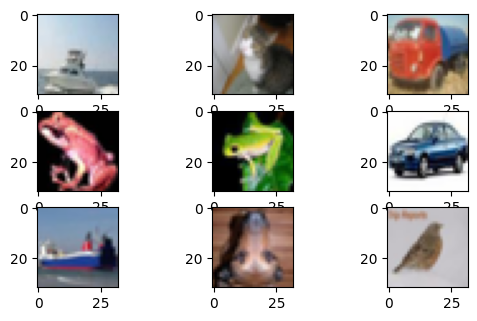

In [35]:
print('Diemnsiones del conjunto de datos de entrenamiento:', x_train.shape)
print('Diemnsiones del conjunto de etiquetas de los datos de entrenamiento:', y_train.shape)
print('Diemnsiones del conjunto de datos de prueba:', x_test.shape)
print('Diemnsiones del conjunto de etiquetas de los datos de prueba:', y_test.shape)

# Plot data
for i in range(100, 109):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i])
plt.show()

Compilamos el modelo y definimos los parámetros de entrenamiento, en este caso se usó un learning rate decreciente con las épocas.

In [36]:
#model_alex = keras.models.load_model(save_models_dir + "alexNet.keras")
model_alex.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.Adam(learning_rate=lr),
                   metrics=["accuracy"])


def scheduler(epoch, lr):
    return lr/(epoch+1)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_models_dir + "alexNet.keras",
        save_best_only=True,
        monitor="accuracy"),
    keras.callbacks.LearningRateScheduler(scheduler)
]

Entrenamos el modelo.

In [ ]:
history = model_alex.fit(
    x=x_train[0:int(len(x_train)*0.8)],
    y=y_train[0:int(len(x_train)*0.8)],
    verbose=1,
    batch_size=batch,
    epochs=epochs,
    validation_data=[x_train[int(len(x_train)*0.8):],
                     y_train[int(len(x_train)*0.8):]],
    callbacks=callbacks)

Evaluamos el modelo con el conjunto de prueba.

In [ ]:
test_loss, test_acc = model_alex.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

La siguiente es una gráfica con la evolución en el entrenamiento del modelo.

In [ ]:
# 6. Plot Training History (Optional but very useful)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Resultados

**PyTorch pre-entrenado**: Para el modelo importado de Torch y pre-entrenado se observó una exactitud general de __83.40%__, y una exactitud por categoria de 

    Accuracy of plane : 91.07 %
    Accuracy of car   : 100.00 %
    Accuracy of bird  : 77.22 %
    Accuracy of cat   : 68.49 %
    Accuracy of deer  : 74.55 %
    Accuracy of dog   : 71.19 %
    Accuracy of frog  : 94.64 %
    Accuracy of horse : 85.94 %
    Accuracy of ship  : 84.48 %
    Accuracy of truck : 87.18 %

La ejecución de este modelo tanto en carga de datos como en entrenamiento fue bastante sencilla y los ajustes necesarios para obtener dicho resultado fueron mínimas, reduciéndose al ajuste de batch y entrenamiento.

**PyTroch desde cero**: Para el modelo generado a partir de cero en torch y con una sola ejecución a traves de todo el conjunto de entrenamiento, se obtuvo una exactitud general de __58.93 %__ con un valor de perdida de __loss: 1.218__, y una exactitud por categoria de 

    Accuracy of plane : 66.07 %
    Accuracy of car   : 62.00 %
    Accuracy of bird  : 45.57 %
    Accuracy of cat   : 38.36 %
    Accuracy of deer  : 30.91 %
    Accuracy of dog   : 54.24 %
    Accuracy of frog  : 62.50 %
    Accuracy of horse : 59.38 %
    Accuracy of ship  : 68.97 %
    Accuracy of truck : 71.79 %

En el caso de este modelo, si bien el generar el modelo resultó más complicado que simplemente importarlo ya entrenado, la definición de la arquitectura fue relativamente sencilla, ya que no es una arquitectura demasiado extensa.

**Tensorflow/Keras desde cero**: El modelo de tensorflow/keras creado desde cero y con 3 entrenamientos de 10 épocas cada uno y recargando el mejor resultado del ciclo anterior, obtuvo una exactitud general de __67.3%__ y una perdida de __0.919__ durante el entrenamiento, pero registrando solamente __59.3%__ de exactitud y __1.207__ de perdida al evaluarlo sobre los datos de prueba, los cuales no había observado nunca antes.

#### Conclusiones

El modelo pre-entrenado de Alexnet fue sin lugar a dudas el que obtuvo los mejores resultados, esto tiene todo el sentido ya que es un modelo entrenado con una enorme cantidad de datos y durante un gran número de épocas, lo que le permite partir de un estado muy cómodo y adaptarse rápidamente y con buenos resultados a la clasificación de un grupo de imágenes. 

Para el caso de los modelos generados desde cero, se obtuvieron resultados similares en ambos casos, rondando el 60% de exactitud general, esto es esperado ya que al ser un modelo entrenado a partir de cero y durante pocas épocas, se parte desde un punto de partida básico y aumentando poco a poco la exactitud del modelo, otro factor que afecta en su desempeño es la cantidad menor de datos de entrenamiento utilizados, ya que el estar utilizando el conjunto de CIFAR10 solamente tenemos 10 categorías de imágenes sobre las que se entrena y una cantidad relativamente pequeña, sabiendo esto podemos observar principalmente en el modelo de Tf/Keras un posible comportamiento de overfitting que se alcanza rápidamente y no permite generalizar de manera correcta para imágenes no vistas previamente, por esta razón podemos observar que la exactitud disminuye en el conjunto de test respecto al observado durante entrenamiento.

Como conclusión el modelo pre-entrando fue el ganador indiscutible, sin embargo los modelos generados desde cero si lograron tener una exactitud más allá de un valor aleatorio, que sin llegar al desempeño del modelo pre-entrenado si se tiene una clasificación aceptable. Con mayor cantidad de épocas al entrenar seguramente se logrará un mejor desempeño, también jugar con mayor variedad de hiperparametros como el batch size, learning rate, épocas, y utilidades de la red como dropout o padding también ayudará a mejorar el desempeño del modelo.

